In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import json

In [63]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tt = line.get_table()
tw = line.twiss()

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [3]:
def install_tidp(line, block_mvt=29e-3):
    tidp_ap_tot = 147e-3
    line.discard_tracker()
    tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
    line.collimators.install(names=['tidp.11434'], elements=[tidp])
    return tidp

def install_tcsm(line):
    tcsm = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
    line.collimators.install(names=['tcsm.51932'], elements=[tcsm])
    return tcsm

def install_offmom_bpms_colls(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    tw = line.twiss()
    tt = line.get_table()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    colls = []
    aper_to_remove = []
    for nn in offmom_bpms:
        aper_to_remove.append(f'{nn}.a_aper')
        aper_to_remove.append(f'{nn}.b_aper')
        if line[nn+'.a_aper'].__class__.__name__ == 'LimitEllipse':
            jaw = line[nn+'.a_aper'].a
        else:
            jaw = line[nn+'.a_aper'].max_x
        
        colls.append(xc.EverestCollimator(length=line[nn].length, material=xc.materials.Beryllium, jaw=jaw))
    line.remove(aper_to_remove)
    line.collimators.install(names=offmom_bpms, elements=colls)
    return colls

def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [37]:
remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

# Checking sagitta implies -5.3mm shift at end of vebb

In [13]:
L = line['mbb.10070'].length
R = 1/line['mbb.10070'].k0
angle = 2*np.pi/744

In [16]:
def func(s, s0, x0, angle=angle, R=R):
    return -np.tan(angle/2) * (s-s0) + x0

In [19]:
s0 = L/2
x0 = -4.4e-3
print(func(L/2, s0, x0), func(L/2 + line.get_s_position('vebb.10070.b_aper') - line.get_s_position('mbb.10070_exit'), s0, x0))

-0.0044 -0.005225055956482894


Gives -5.225mm, which is ok

# VEBB and VEBA apertures need to be shifted as well

In [38]:
veb_b_apers = tt.rows['veb.*.b_aper'].name

In [40]:
for name in veb_b_apers:
    line[name].shift_x += 5.3e-3

In [65]:
tt = line.get_table()
tw = line.twiss()

In [66]:
import apertls
ap_calc = apertls.ApertureCalculator(line)
x_ext = ap_calc.compute_x_extent()

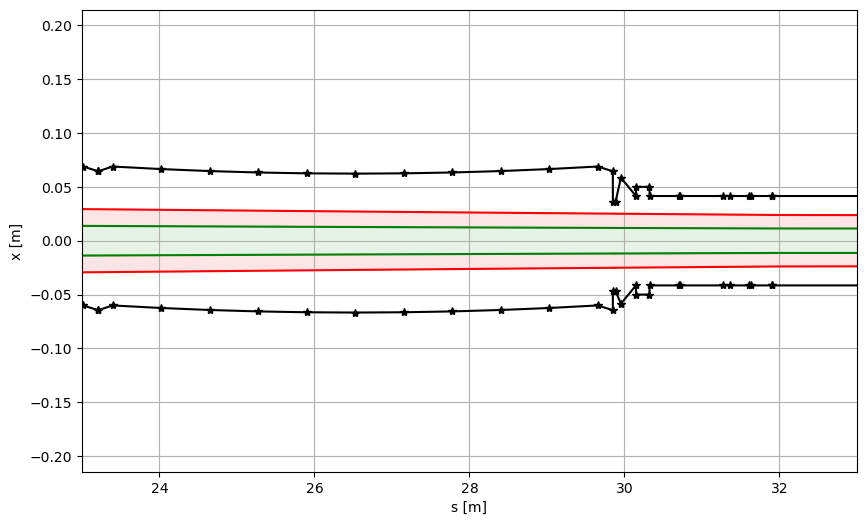

In [67]:
exn=3.5e-6
nrj=21
pmass=0.938
bucket_height=3e-3
n_buckets = 1

mask = np.array([line[nn].__class__.__name__.startswith('Limit') for nn in tt.name[:-1]])
mask = np.concatenate((mask, [False]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tt.s[mask], x_ext[:, 0], '*-', color='k')
ax.plot(tt.s[mask], x_ext[:, 1], '*-', color='k')
ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', label='5 sigma')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='green')

ax.plot(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, color='red', label='5 sigma + bucket')
ax.plot(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, color='red')

ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj), 5*np.sqrt(tw.betx*exn*pmass/nrj), color='green', alpha=0.1)
ax.fill_between(tw.s, -5*np.sqrt(tw.betx*exn*pmass/nrj)-n_buckets*bucket_height*tw.dx, -5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.fill_between(tw.s, 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx, 5*np.sqrt(tw.betx*exn*pmass/nrj), color='red', alpha=0.1)
ax.grid()
# ax.legend()
ax.set_xlim(23,33)
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.hlines(0.02, 5200, 6200)
# plt.savefig('x_extent_with_bucket.pdf', dpi=300)
plt.show()

# Installing collimator flanges

## New flanges

Start with apertures to generate slices, then we can fill with collimators

In [44]:
L1 = 34e-3
L2 = 70e-3

r1 = 41.5e-3
r2 = 60e-3-1.5e-3
r3 = 51.5e-3

In [45]:
changed = [10110, 11110, 11310, 12510, 13510, 20910, 21110, 22510, 23510, 30110, 30910,
32510, 33510, 40110, 40910, 41110, 42510, 42710, 51110, 52510, 53510, 60110,
61110, 62510, 63510]

In [64]:
env = line.env

insertions = []
for nn in changed:
    nn_flange = f'vcak.{nn-9}.a_aper'
    line[nn_flange].shift_x -=5.3e-3

    #Add apertures for intermediate flanges
    start_flange = line.get_s_position(nn_flange)
    
    s_aper_c = start_flange + L1
    s_aper_d = start_flange + L1 + L2
    s_aper_e = start_flange + L1 + L2
    
    env.elements[f'vcak.{nn-9}.c_aper'] = xt.LimitEllipse(a=r1, b=r1, shift_x = -5.3e-3)
    insertions.append(env.place(f'vcak.{nn-9}.c_aper', at=s_aper_c))
    env.elements[f'vcak.{nn-9}.d_aper'] = xt.LimitEllipse(a=r1, b=r1, shift_x = -5.3e-3)
    insertions.append(env.place(f'vcak.{nn-9}.d_aper', at=s_aper_d))

    env.elements[f'vcak.{nn-9}.d_aper'] = xt.LimitEllipse(a=r2, b=r2)
    insertions.append(env.place(f'vcak.{nn-9}.d_aper', at=s_aper_d))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/32538 [00:00<?, ?it/s]

In [55]:
line.get_s_position('vcak.10101.a_aper') + L1

np.float64(29.885599999999997)

In [53]:
for nn in changed:
    print(nn, tt.rows[f'.*{nn-9}.*'].name)

10110 ['vcak.10101.a_aper' 'vcak.10101.b_aper']
11110 ['vcak.11101.a_aper' 'vcak.11101.b_aper']
11310 ['vcak.11301.a_aper' 'vcak.11301.b_aper']
12510 ['vcak.12501.a_aper' 'vcak.12501.b_aper']
13510 ['vcak.13501.a_aper' 'vcak.13501.b_aper']
20910 ['vcak.20901.a_aper' 'vcak.20901.b_aper']
21110 ['vcak.21101.a_aper' 'vcak.21101.b_aper']
22510 ['vcak.22501.a_aper' 'vcak.22501.b_aper']
23510 ['vcak.23501.a_aper' 'vcak.23501.b_aper']
30110 ['vcak.30101.a_aper' 'vcak.30101.b_aper']
30910 ['vcak.30901.a_aper' 'vcak.30901.b_aper']
32510 ['vcak.32501.a_aper' 'vcak.32501.b_aper']
33510 ['vcak.33501.a_aper' 'vcak.33501.b_aper']
40110 ['vcak.40101.a_aper' 'vcak.40101.b_aper']
40910 ['vcak.40901.a_aper' 'vcak.40901.b_aper']
41110 ['vcak.41101.a_aper' 'vcak.41101.b_aper']
42510 ['vcak.42501.a_aper' 'vcak.42501.b_aper']
42710 ['vcak.42701.a_aper' 'vcak.42701.b_aper']
51110 ['vcak.51101.a_aper' 'vcak.51101.b_aper']
52510 ['vcak.52501.a_aper' 'vcak.52501.b_aper']
53510 ['vcak.53501.a_aper' 'vcak.53501.b